In [1]:
import pandas as pd
import os, sys
%matplotlib inline

from IPython.display import display, HTML

if (sys.version_info < (3, 0)):
    HTML('''<script>
    code_show=true; 
    function code_toggle() {
     if (code_show){
     $('div.input').hide();
     } else {
     $('div.input').show();
     }
     code_show = !code_show
    } 
    $( document ).ready(code_toggle);
    </script>
    <form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [2]:
working_dir = r'../../../../outputs/agg/dash'


In [3]:
def load_data(fname):
    """ open and join model and survey data """

    df_model = pd.read_csv(os.path.join(working_dir,fname+'.csv'))
    df_model['source'] = 'model'
    df_survey = pd.read_csv(os.path.join(working_dir,'survey',fname+'.csv'))
    df_survey['source'] = 'survey'
    df = df_model.append(df_survey)

    return df

In [4]:
district_lookup = {1: 'Suburban Snohomish',
                  2: 'Everett-Lynwood-Edmonds',
                  3: 'North Seattle-Shoreline',
                  4: 'Seattle CBD',
                  5: 'West-South Seattle',
                  6: 'East Side',
                   7: 'Renton-FedWay-Kent',
                   8: 'Tacoma',
                   9: 'Kitsap',
                   10: 'South Pierce',
                   11: 'S.Kitsap'
                  }

# Trips by Purpose

source,model,survey
dpurp,,
Change Mode Inserted Purpose,0.2%,NaN
Escort,10.8%,12.0%
Meal,7.3%,6.3%
None/Home,32.7%,33.0%
Personal Business,4.9%,5.1%
School,4.0%,4.1%
Shop,10.3%,11.1%
Social,13.8%,14.0%
Work,16.0%,14.3%


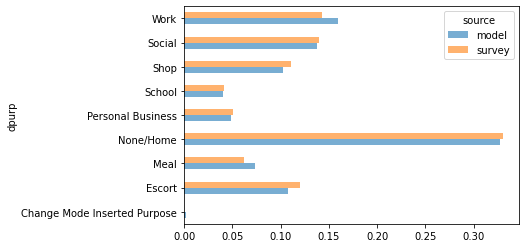

In [5]:
pd.options.display.float_format = '{:0,.1%}'.format

df = load_data('trip_purpose_mode')
df_purp = pd.DataFrame()
for source in ['model','survey']:
    _df = df[(df['source'] == source)]
    df2 = _df.groupby('dpurp').sum()[['trexpfac']].reset_index()
    df2['source'] = source
    df_purp = df_purp.append(df2)

df = df_purp.pivot_table(index='dpurp', columns='source', aggfunc='sum', values='trexpfac')
df = df/df.sum()
df.plot(kind='barh', alpha=0.6)
df

# Average Distance by Trip Purpose 

source,model,survey
dpurp,,
Escort,4.07,5.34
Meal,3.09,3.90
None/Home,5.30,6.08
Personal Business,4.34,5.39
School,3.59,3.78
Shop,3.92,4.02
Social,5.30,5.89
Work,7.51,8.65


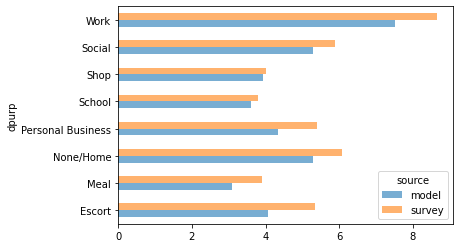

In [6]:
pd.options.display.float_format = '{:0,.2f}'.format
df = load_data('trip_distance')
# Trim any unreasonable survey distances off by taking max distance as max modeled bin value
max_model_dist = df.loc[(df['source']=='model'), 'travdist_bin'].max()
df = df.loc[df['travdist_bin'] <= max_model_dist]
df['wt_autodist'] = (df['travdist_bin']+0.5)*(df['trexpfac'])
df_dist = pd.DataFrame()
for source in ['model','survey']:
    _df = df[(df['source'] == source)]
    df1 = _df.groupby('dpurp').sum()[['wt_autodist']].reset_index()
    df2 = _df.groupby('dpurp').sum()[['trexpfac']].reset_index ()
    _df = df1.merge(df2, on='dpurp')
    _df['wt_distance'] = _df['wt_autodist']/_df['trexpfac']
    _df['source'] = source
    df_dist = df_dist.append(_df)
df = df_dist.pivot_table(index='dpurp', columns='source', aggfunc='first', values='wt_distance')
df.rename(columns={'dpurp': 'Tour Purpose'}, inplace=True)
df.drop('Change Mode Inserted Purpose', axis=0, inplace=True)
df.plot(kind='barh', alpha=0.6)
df

# Average Distance by Trip Mode

source,model,survey
mode,,
Bike,3.73,3.97
HOV2,4.89,5.24
HOV3+,5.07,6.31
SOV,6.28,6.90
School Bus,3.44,2.73
TNC,4.92,6.04
Transit,5.25,10.08
Walk,1.08,0.96


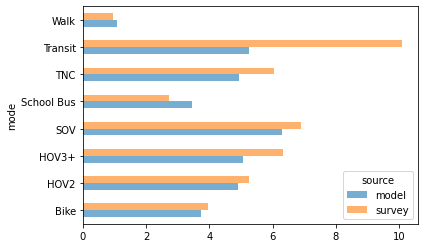

In [7]:
df = load_data('trip_distance')
# Trim any unreasonable survey distances off by taking max distance as max modeled bin value
max_model_dist = df.loc[(df['source']=='model'), 'travdist_bin'].max()
df = df.loc[df['travdist_bin'] <= max_model_dist]
df['wt_autodist'] = (df['travdist_bin']+0.5)*(df['trexpfac'])
df_dist = pd.DataFrame()
for source in ['model','survey']:
    _df = df[(df['source'] == source)]
    df1 = _df.groupby('mode').sum()[['wt_autodist']].reset_index()
    df2 = _df.groupby('mode').sum()[['trexpfac']].reset_index ()
    _df = df1.merge(df2, on='mode')
    _df['wt_distance'] = _df['wt_autodist']/_df['trexpfac']
    _df['source'] = source
    df_dist = df_dist.append(_df)
df = df_dist.pivot_table(index='mode', columns='source', aggfunc='first', values='wt_distance')
df.rename(columns={'dpurp': 'Tour Purpose'}, inplace=True)
df.plot(kind='barh', alpha=0.6)
df

# Trip Destination District

,model,survey
Suburban Snohomish,11.16%,13.45%
Everett-Lynwood-Edmonds,8.14%,3.74%
North Seattle-Shoreline,6.94%,9.56%
Seattle CBD,11.05%,4.29%
West-South Seattle,5.71%,6.55%
East Side,15.63%,17.74%
Renton-FedWay-Kent,14.95%,17.76%
Tacoma,7.11%,3.12%
Kitsap,5.95%,8.23%
South Pierce,11.93%,12.27%


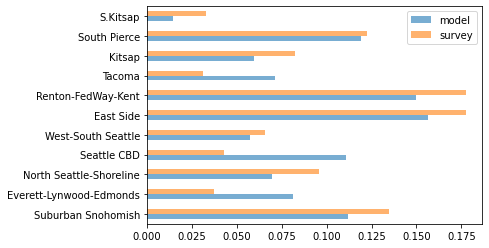

In [8]:
pd.options.display.float_format = '{:0,.2%}'.format

_df = pd.DataFrame()
for id, name in district_lookup.items():
    df = load_data('tour_total_tour_d_district_'+name)
    for source in ['model','survey']:
        _df.loc[name,source] = df[df['source'] == source]['toexpfac'].sum()
        
_df = _df/_df.sum()
_df.plot(kind='barh', alpha=0.6)
_df